In [594]:
import pandas as pd
import IPython.display as disp
import requests
import math
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy import spatial  #distancia: cosseno
from scipy.sparse import csc_matrix #matrix esparsa usada pros vetores
from numpy import dot
from numpy.linalg import norm
from colorama import Fore, Back, Style       #prints coloridos e estilizados

def print_destaque(texto):
    print(Back.BLUE + Fore.LIGHTYELLOW_EX+ f' {texto} ')
    print(Style.RESET_ALL)

## carregar ratings

In [32]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.drop('timestamp', axis=1)     #remover a coluna timestamp. Informação irrelevante
disp.display(ratings.head(3))
print(f'Temos na base principal {len(ratings.userId.unique())} usuários')

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0


Temos na base principal 162541 usuários


## carregar sinopses e retirar ratings de filmes sem sinopses

In [65]:
ratings = ratings.sort_values(by=['userId', 'rating'], ascending=False) #ordernar por rating em cada usuário para futuramente selecionar os ratings mais relevantes
sinopses = pd.read_csv('movies2.csv')
filmes_sem_sinopse = sinopses[sinopses['sinopse'].isnull()]['movieId'].tolist()
ratings = ratings[~ratings['movieId'].isin(filmes_sem_sinopse)] #retirar ratings dos filmes que não tem sinopse
ratings.head()

,userId,movieId,rating
24999913,162541,29,5.0
24999914,162541,32,5.0
24999916,162541,50,5.0
24999923,162541,260,5.0
24999935,162541,541,5.0


## usuários = 10 filmes mais bem cotados por usuário

In [34]:
usuarios = ratings.groupby('userId').apply(lambda x: x.iloc[:10]) #agrupar por usuários mantendo só as 10 primeiras linhas de cada
usuarios = usuarios.reset_index(level=0, drop=True)
usuarios.head()

,userId,movieId,rating
0,1,296,5.0
2,1,307,5.0
3,1,665,5.0
8,1,1237,5.0
18,1,2632,5.0


## retirar sinopses de filmes não assistidos

In [576]:
sinopses = sinopses[sinopses['movieId'].isin(usuarios.movieId.unique())] #manter no DF Sinopses apenas os filmes que participam das preferencias dos usuários
sinopses = sinopses.reset_index(drop=True)
def get_posicao_do_filme(movieId:int):
    return sinopses.index[sinopses['movieId']==movieId][0]
sinopses

,movieId,title,genres,titulo,ano,sinopse
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995,When siblings Judy and Peter discover an encha...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,A family wedding reignites the ancient feud be...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995,"Cheated on, mistreated and stepped on, the wom..."
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...
11468,207311,Last Christmas (2019),Comedy|Romance,Last Christmas,2019,Kate is a young woman who has a habit of makin...
11469,207834,Jenny Slate: Stage Fright (2019),Comedy|Documentary,Jenny Slate: Stage Fright,2019,Jenny Slate's first stand-up special is a mix ...
11470,207888,Black and Blue (2019),Action|Crime|Drama,Black and Blue,2019,A rookie cop inadvertently captures the murder...
11471,208006,Chhichhore (2019),Comedy|Romance,Chhichhore,2019,Following a group of friends from university a...


## filmes_plano_vetor: matriz esparsa com score TFIDF das palavras
termos: vetor das palavras em todo o corpus

In [390]:
# Criar um objeto de transformação de TF-IDF
vetor_palavras = TfidfVectorizer(stop_words='english')

# Ajustar o objeto de transformação aos resumos de filmes
filmes_plano_vetor = vetor_palavras.fit_transform(sinopses.sinopse)

# Obter uma lista de todos os termos presentes nos resumos
termos = vetor_palavras.get_feature_names_out()
qtd_termos = len(termos)

In [407]:
def get_pos_termo(palavra: str):
    return np.where(termos == palavra)[0][0]

In [334]:
a = np.array([0,1,2])
a = np.vstack((a,a*2))
a


array([[0, 1, 2],
       [0, 2, 4]])

In [335]:
a[1,1]

2

In [722]:
def get_tfidf_filme(movieId: int, log = False):
    try:
        posicao = sinopses[sinopses['movieId']== movieId].index[0]
    except IndexError:
        return "Filme não existe"
    titulo = sinopses.loc[posicao]['titulo']
    sinopse = sinopses.loc[posicao]['sinopse']
    if(log):
        print(titulo, '\n', sinopse)
    lista_termos = [termos[i] for i in filmes_plano_vetor.getrow(posicao).indices]
    lista_scores = filmes_plano_vetor.getrow(posicao).data
    return dict(zip(lista_termos, lista_scores))

In [940]:
def criar_lista_termos_usuario(userId):
    dicionario = dict()
    lista_filmes = usuarios[usuarios['userId']==userId]['movieId'].to_numpy()
    for filme in lista_filmes:
        termos_filme = get_tfidf_filme(filme)
        for chave, valor in termos_filme.items():
            if chave in dicionario:                 #Se a palavra já existe no texto do usuário
                dicionario[chave] = math.tanh(dicionario[chave]+valor) #Ela ganha um score mais alto usando tangente hiperbólica (max=1)
            else:
                dicionario[chave] = valor
    return sorted(dicionario.items(), key=lambda kv: kv[1],reverse=True) #retorna lista de tuplas com termos e tfidf score descendentemente

def criar_texto_usuario(lista_termos: list):
    texto = str()
    for tupla in lista_termos:
        texto += tupla[0] + ' '
    return texto

def criar_vetor_usuario(lista_termos=None, userId=0):
    if(userId != 0):
        lista_termos = criar_lista_termos_usuario(userId)
    vetor = np.array([np.zeros(qtd_termos)])[0]
    for chave, valor in lista_termos:
        vetor[get_pos_termo(chave)] = valor
    return csc_matrix(vetor)   


In [717]:
get_tfidf_filme(296, log=True)

Pulp Fiction 
 A burger-loving hit man, his philosophical partner, a drug-addled gangster's moll and a washed-up boxer converge in this sprawling, comedic crime caper. Their adventures unfurl in three stories that ingeniously trip back and forth in time.


{'forth': 0.22856712413794955,
 'ingeniously': 0.27757997099847637,
 'stories': 0.16083904465991555,
 'unfurl': 0.27757997099847637,
 'caper': 0.24599400465615298,
 'comedic': 0.2160513876139889,
 'sprawling': 0.23130736668068488,
 'boxer': 0.19877866717331255,
 'washed': 0.2237641879702544,
 'moll': 0.2576514450377979,
 'addled': 0.25123589264136337,
 'philosophical': 0.23130736668068488,
 'burger': 0.24156205151409138,
 'loving': 0.17979287437768304,
 'drug': 0.14432787165641545,
 'trip': 0.146956676906245,
 'gangster': 0.17793734119508411,
 'converge': 0.2237641879702544,
 'hit': 0.1558460827801334,
 'partner': 0.1598643484170046,
 'crime': 0.14256845120314593,
 'adventures': 0.17046335815120883,
 'man': 0.09473722634746612,
 'time': 0.10706141795524449}

In [529]:
a = np.array([np.zeros(10)])[0]
a[7]=1
a[0]
a.shape

(10,)

In [553]:
texto_usuario_2 = sorted(criar_lista_termos_usuario(2).items(), key=lambda kv: kv[1],reverse=True)
vetor_usuario_2 = criar_vetor_usuario(texto_usuario_2)
vetor_usuario_2

<1x32233 sparse matrix of type '<class 'numpy.float64'>'
	with 222 stored elements in Compressed Sparse Column format>

In [435]:
vetor_usuario_1.todense()

matrix([], shape=(32154, 0), dtype=float64)

In [575]:
def get_filme(movieId:int, args=['titulo', 'ano']):
    return sinopses[sinopses['movieId']==movieId][args]

def get_filme_na_loc(posicao:int, args=['titulo', 'ano']):
    return sinopses.loc[posicao][args]

def get_filmes_usuario(id:int):
    return usuarios[usuarios.userId==id].merge(sinopses[['movieId','titulo', 'ano','sinopse']], left_on='movieId', right_on='movieId')
get_filmes_usuario(7).head(3)

,userId,movieId,rating,titulo,ano,sinopse
0,7,58,5.0,"Postman, The (Postino, Il)",1994,Simple Italian postman learns to love poetry w...
1,7,306,5.0,Three Colors: Red (Trois couleurs: Rouge),1994,"Valentine, a student model in Geneva, struggle..."
2,7,527,5.0,Schindler's List,1993,The true story of how businessman Oskar Schind...


In [200]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([filmes_plano_vetor.getrow(1).toarray()[0],filmes_plano_vetor.getrow(2).toarray()[0]])
#ValueError: setting an array element with a sequence.
#filmes_plano_vetor.getrow(1).toarray()
#cosine_similarity([[1,2,2,3,1,2,2,3],[1,2,2,3,1,2,2,3]])

array([[1.        , 0.04920363],
       [0.04920363, 1.        ]])

# retornar uma lista dos mais similares igual a função do trabalho anterior

In [423]:
jumangi_vetor

array([0., 0., 0., ..., 0., 0., 0.])

In [560]:
get_filmes_usuario(1)

,userId,movieId,rating,titulo,ano,sinopse
0,1,296,5.0,Pulp Fiction,1994,"A burger-loving hit man, his philosophical par..."
1,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu),1993,Julie is haunted by her grief after living thr...
2,1,665,5.0,Underground,1995,Black marketeers Marko and Blacky manufacture ...
3,1,1237,5.0,"Seventh Seal, The (Sjunde inseglet, Det)",1957,When disillusioned Swedish knight Antonius Blo...
4,1,2632,5.0,"Saragossa Manuscript, The (Rekopis znaleziony ...",1965,"In the Napoleonic wars, an officer finds an ol..."
5,1,2692,5.0,Run Lola Run (Lola rennt),1998,Lola receives a phone call from her boyfriend ...
6,1,3569,5.0,"Idiots, The (Idioterne)",1998,With his first Dogma-95 film director Lars von...
7,1,3949,5.0,Requiem for a Dream,2000,The hopes and dreams of four ambitious people ...
8,1,4144,5.0,In the Mood For Love (Fa yeung nin wa),2000,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo..."
9,1,4325,5.0,"Night, The (Notte, La)",1960,"1943. The affair between Anna, unhappily marri..."


In [465]:
get_posicao_do_filme(296)

284

In [537]:
for filme in get_filmes_usuario(1)['movieId'].to_list():
    pos = get_pos_filme(filme)
    print(comparar_vetores_esparsos(filmes_plano_vetor.getrow(pos),criar_vetor_usuario(texto_usuario_1)))

0.3284780588620847
0.32819137065530213
0.32925892796114975
0.32133577374901745
0.3362131129243492
0.3100596089255163
0.3267494609765945
0.323959611804318
0.3100596089255163
0.3171274686541995


In [488]:
def comparar_vetores_esparsos(a:csc_matrix, b:csc_matrix):
    a, b = a.toarray()[0], b.toarray()[0]
    return 1 - spatial.distance.cosine(a, b)

In [489]:
comparar_vetores_esparsos(filmes_plano_vetor.getrow(2301),criar_vetor_usuario(texto_usuario_1))

0.3362131129243492

In [644]:
array_movieId_filmes = np.array()
array_movieId_filmes

array([     1,      2,      3, ..., 207888, 208006, 208265])

In [738]:
def get_mais_similares(vetor):
    lista_similaridades = []
    lista_movieIds = sinopses['movieId'].to_list()
    lista_linhas_zeradas = []
    for linha in range(filmes_plano_vetor.shape[0]): #percorrer cada linha com filmes no vetor 
        linha_vetor = filmes_plano_vetor.getrow(linha)#.toarray()[0]
        '''  TESTE DE OTIMIZACAO CHECANDO INTERSESSAO ANTES DE CALCULAR COSSENO: FALHOU 20% mais lento 
        if(set(vetor.nonzero()[1]).intersection(linha_vetor.nonzero()[1])): #Se há interseção dos vetores
            #cos_sim = dot(vetor.toarray()[0], linha_vetor.toarray()[0])#/(norm(vetor)*norm(linha_vetor)) #MUITO LENTO USANDO NUMPY
            cos_sim = 1 - spatial.distance.cosine(vetor.toarray()[0], linha_vetor.toarray()[0]) #calcula o cosseno
        else:
            cos_sim = 0         #senão o cosseno é zero
        '''
        cos_sim = 1 - spatial.distance.cosine(vetor.toarray()[0], linha_vetor.toarray()[0])
        if(cos_sim > 0):
            lista_similaridades.append(cos_sim)
        else:
            lista_linhas_zeradas.append(linha)
    for linha in sorted(lista_linhas_zeradas, reverse=True):
        lista_movieIds.pop(linha)

    ordenados = list(zip(*sorted(zip(lista_similaridades, lista_movieIds), key=lambda x: x[0], reverse=True) ))
    return ordenados

In [ ]:
termos_star_wars = {'star': 1.0, 'wars':1.0}.items()
usuario_star_wars = criar_vetor_usuario(termos_star_wars)
scores_similares_star_wars,filmes_similares_star_wars = get_mais_similares(usuario_star_wars)
for i in range(20):
    print(sinopses[sinopses['movieId']==filmes_similares_star_wars[i]])


In [739]:
def recomendar_filmes(usuario:int):
    filmes_vistos_pelo_usuario = get_filmes_usuario(usuario)['movieId'].to_list()
    termos_usuario = criar_lista_termos_usuario(usuario)

    vetor_usuario = criar_vetor_usuario(termos_usuario)
    similaridades, filmes_similares = get_mais_similares(vetor_usuario)

    print_destaque("Filmes do usuário "+str(usuario))
    display(get_filmes_usuario(usuario))
    print_destaque("Texto do usuário "+str(usuario))
    print(criar_texto_usuario(termos_usuario)[:600])
    recomendacoes = [filme for filme in filmes_similares if filme not in set(filmes_vistos_pelo_usuario)]
    print()
    print_destaque(f"Recomendados, {len(recomendacoes)} filmes:")

    #print(filmes_similares[:100])
    #print(recomendacoes[:100])
    #print("todos que ele ja viu:")
    #print(ratings[ratings['userId']==usuario]['movieId'].to_list())
    
    display(sinopses[sinopses['movieId'].isin(recomendacoes[:20])][['movieId','titulo', 'ano', 'sinopse']])

    # Excluir os filmes vistos das recomendações e retornar como recomendação e avaliar eficacia
    
recomendar_filmes(1)


 Filmes do usuário 1 



,userId,movieId,rating,titulo,ano,sinopse
0,1,296,5.0,Pulp Fiction,1994,"A burger-loving hit man, his philosophical par..."
1,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu),1993,Julie is haunted by her grief after living thr...
2,1,665,5.0,Underground,1995,Black marketeers Marko and Blacky manufacture ...
3,1,1237,5.0,"Seventh Seal, The (Sjunde inseglet, Det)",1957,When disillusioned Swedish knight Antonius Blo...
4,1,2632,5.0,"Saragossa Manuscript, The (Rekopis znaleziony ...",1965,"In the Napoleonic wars, an officer finds an ol..."
5,1,2692,5.0,Run Lola Run (Lola rennt),1998,Lola receives a phone call from her boyfriend ...
6,1,3569,5.0,"Idiots, The (Idioterne)",1998,With his first Dogma-95 film director Lars von...
7,1,3949,5.0,Requiem for a Dream,2000,The hopes and dreams of four ambitious people ...
8,1,4144,5.0,In the Mood For Love (Fa yeung nin wa),2000,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo..."
9,1,4325,5.0,"Night, The (Notte, La)",1960,"1943. The affair between Anna, unhappily marri..."


 Texto do usuário 1 

marko manni pino lola franco blacky addictions inner overcomes drug spiraling block stories quemada venta ranks film addiction death shattered gallows su chow people ingeniously unfurl zhen ambitious moll communist polite formal mo addled wan apartments spouses li dogma caper burger mind meets withdraw trier hopes sprawling philosophical forth redemptive jof antonius washed converge neighboring body platform 95 lars alternatives dm depending eventually wakes styles 1962 control comedic look idiots lock black begin olivier interactions tells story dreams bustling suppress intertwining ferrara f

 Recomendados, 10496 filmes: 



,movieId,titulo,ano,sinopse
1517,1701,Deconstructing Harry,1997,This film tells the story of a successful writ...
2871,3328,Ghost Dog: The Way of the Samurai,1999,An African-American Mafia hit man who models h...
2947,3433,Death Wish 4: The Crackdown,1987,After the death of his girlfriend's daughter f...
3192,3747,Jesus' Son,1999,A young man turns from drug addiction and pett...
4068,4970,"Blue Angel, The (Blaue Engel, Der)",1930,Prim professor Immanuel Rath finds some of his...
4674,6032,A Little Romance,1979,A young American girl and a young French boy m...
4888,6436,This Boy's Life,1993,When a son and mother move to Seattle in hopes...
5933,8930,"Five Obstructions, The (Fem benspænd, De)",2003,"Lars von Trier challenges his mentor, filmmake..."
6305,27674,11:14,2003,Tells the seemingly random yet vitally connect...
6379,30712,The Narrow Margin,1952,A tough cop meets his match when he has to gua...


In [895]:
filmes_plano_vetor.shape

(11473, 32233)

In [770]:
for a, b in usuarios[usuarios['userId']==1][['movieId','rating']].to_numpy():
    print(a,b)

296.0 5.0
307.0 5.0
665.0 5.0
1237.0 5.0
2632.0 5.0
2692.0 5.0
3569.0 5.0
3949.0 5.0
4144.0 5.0
4325.0 5.0


In [893]:
import numpy as np
from sklearn.metrics import average_precision_score, ndcg_score

def calcular_map(qt_usuarios = 200):
    # |     | filme1| filme2| filme3| filme4| filme5| filme6
    # |user1|
    # |user2|
    # |user3|
    colunas_matriz_true = sinopses['movieId'].to_numpy()
    linhas_matriz_true = usuarios['userId'].unique()[:(qt_usuarios)]
    matriz_true_bin = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_true_real = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_score = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_assistidos = np.zeros(qt_usuarios)
    linha = 0
    for user in linhas_matriz_true:
        for filme, nota in ratings[ratings['userId']==user][['movieId','rating']].to_numpy():
            posicao_filme = np.where(colunas_matriz_true==filme)
            matriz_true_bin[linha][posicao_filme] = 1
            matriz_true_real[linha][posicao_filme] = nota
            matriz_assistidos[linha] += 1
        coluna = 0
        vetor_user = criar_vetor_usuario(userId=user)
        for filme in colunas_matriz_true:
            matriz_score[linha][coluna] = 1 - spatial.distance.cosine(filmes_plano_vetor.getrow(coluna).toarray()[0], vetor_user.toarray()[0])
            coluna += 1
        linha += 1
    metrica_map = []
    for linha in range(len(linhas_matriz_true)):
        metrica_map.append(average_precision_score(matriz_true_bin[linha], matriz_score[linha]))

    return matriz_true_bin, matriz_score, metrica_map, matriz_assistidos, matriz_true_real

matriz_true, matriz_score, metrica_map, matriz_assistidos, matriz_true_real = calcular_map()

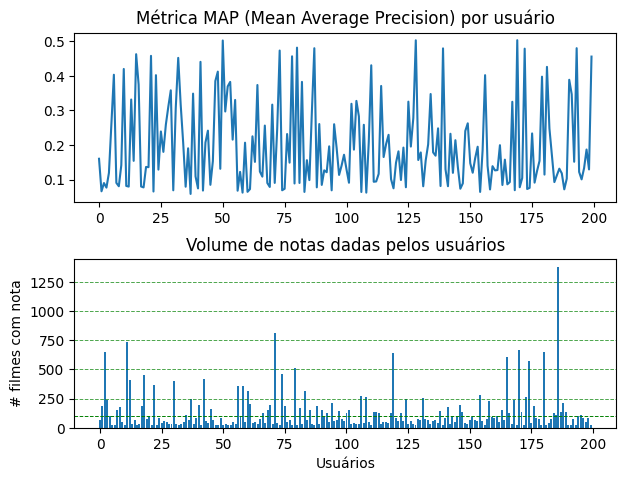

0.637400558622027

In [894]:
import matplotlib.pyplot as plt
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2)
figure.tight_layout(pad=2)
  
maps = []
for linha in range(len(matriz_score)):
    maps.append(average_precision_score(matriz_true[linha], matriz_score[linha]))
# Gráfico 1
axis[0].plot(maps)
axis[0].set_title("Métrica MAP (Mean Average Precision) por usuário")
  
# Gráfico 2
axis[1].bar(range(len(matriz_assistidos)), matriz_assistidos)
axis[1].grid(color='green', linestyle='--', linewidth=0.7, axis='y', alpha=0.7)
axis[1].set_title('Volume de notas dadas pelos usuários')
axis[1].set_xlabel('Usuários')
axis[1].set_ylabel('# filmes com nota')
axis[1].axhline(100, color='green', linestyle='--', linewidth=0.7)
  
plt.show()
ndcg_score(matriz_true,matriz_score, k=None, ignore_ties=True)

In [918]:
ratings[ratings['userId']==187]


,userId,movieId,rating
23901,187,47,5.0
23927,187,293,5.0
23932,187,344,5.0
23986,187,1136,5.0
23988,187,1194,5.0
...,...,...,...
25164,187,91104,1.5
25219,187,98203,1.5
24123,187,2555,1.0
24432,187,7846,1.0


In [948]:
for a, b in criar_lista_termos_usuario(187):
    print(a)

sir
truman
garfield
léon
archaeologist
indiana
mathilda
eyeball
isolation
jones
descends
star
dolphins
rock
footsteps
physical
madness
midst
arthur
entire
anthony
pedro
covenant
tweed
miami
dr
troubled
life
social
lancelot
suited
ark
teacher
missing
schneider
sallah
burbank
unending
lawsuits
stabbing
killer
sr
regime
locate
brave
researches
sommerset
case
brody
grail
eminent
celebrated
consumption
broadcasts
classrooms
scoffs
elsa
custodian
rep
including
aspect
det
goes
resumes
man
soap
substitute
sins
administration
trevor
wows
marino
carrey
york
holy
marcus
recovering
mills
novice
sin
pursuing
ventura
afraid
happens
bullies
earned
eternal
nazi
cannon
24
woos
education
earache
ingesting
pacas
tortured
viewers
dea
mascot
effective
hired
nazis
paid
cleaner
technicality
professor
teaching
homicide
haunting
hour
quarterback
considers
unwilling
wiped
seasoned
drives
ditches
knowledge
legendary
opera
detectives
tune
mad
surviving
stoner
ace
thoughts
raucous
government
underwater
kindred
hen

In [949]:
type(termos)

numpy.ndarray

In [952]:
def criar_matrix_usuario_termos(n_users=100):
    matriz_usuarios = usuarios['userId'].unique()[:n_users]
    matriz = np.zeros((n_users,qtd_termos))
    linha = 0
    for usuario in matriz_usuarios:
        for termo, score in criar_lista_termos_usuario(usuario):
            matriz[linha][np.where(termos==termo)] = score
        linha += 1
        
    print(matriz)

criar_matrix_usuario_termos()

[[0.         0.13842508 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [880]:
matriz_true_ndcg = ratings[:13247].groupby(['userId', 'movieId'])['rating'].first().unstack(fill_value=0.0)

In [885]:
matriz_true_ndcg[:50].shape

#ndcg_score(matriz_true_ndcg[:50],matriz_score[:50], k=None, ignore_ties=True)

(50, 5743)

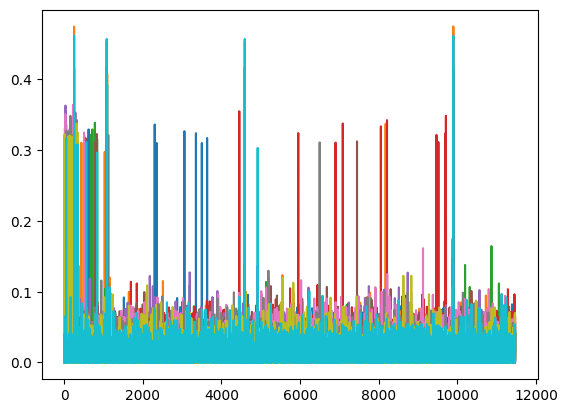

In [558]:
for i in range(10):
    plt.plot(get_mais_similares(criar_vetor_usuario(userId=i+1)))

In [389]:
jumanji_vetor = filmes_plano_vetor.getrow(1).toarray()[0]
jumanji_vetor.shape

(32233,)

<AxesSubplot: >

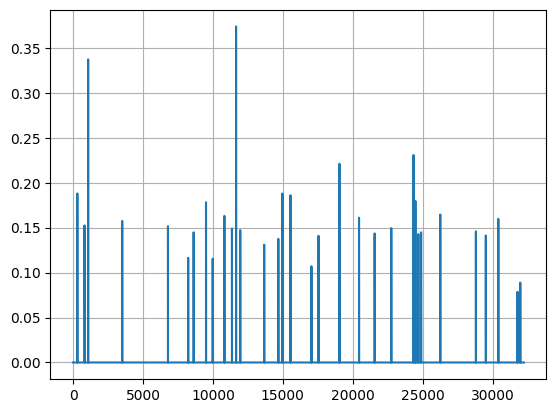

In [262]:
import matplotlib.pyplot as plt
df_jumanji = pd.Series(filmes_plano_vetor.getrow(1).toarray()[0])
df_jumanji.plot(grid=True)


In [173]:
print(filmes_plano_vetor.getrow(1))

  (0, 6787)	0.15159061378348856
  (0, 28798)	0.1458248427323612
  (0, 19044)	0.22113314034252377
  (0, 9985)	0.11548624218505435
  (0, 24337)	0.23082711547870105
  (0, 11953)	0.14723161814365107
  (0, 24882)	0.14482155072389796
  (0, 24476)	0.1796618049159662
  (0, 22750)	0.149510321032683
  (0, 10821)	0.16308984496259096
  (0, 11361)	0.14911513377999672
  (0, 13666)	0.13102467725669734
  (0, 17043)	0.10700681304116957
  (0, 31971)	0.08887081099968128
  (0, 309)	0.18798922043577326
  (0, 14676)	0.13753764300747384
  (0, 29508)	0.14118290551287593
  (0, 824)	0.15247620704293594
  (0, 1081)	0.3372025403268375
  (0, 14969)	0.18798922043577326
  (0, 30402)	0.15980960152361037
  (0, 31773)	0.0785951981738867
  (0, 17548)	0.14090327326736624
  (0, 8622)	0.14482155072389796
  (0, 20445)	0.16106822287789738
  (0, 11655)	0.37383283667850203
  (0, 3516)	0.1574752332207415
  (0, 9507)	0.178295245299596
  (0, 8232)	0.11646622709326751
  (0, 21560)	0.1435461398433293
  (0, 15542)	0.1860755366131628

In [734]:
from sklearn.metrics import average_precision_score, ndcg_score

y_true = [0, 0, 1, 1]
y_score = [0.1, 0.4, 0.35, 0.8]

map = average_precision_score(y_true, y_score)

print("map:", map)


map: 0.8333333333333333


In [729]:
map

0.3333333333333333

In [731]:
from sklearn.metrics import ndcg_score

y_true = [0, 0, 1, 1]
y_score = [0.1, 0.4, 0.35, 0.8]

ndcg = ndcg_score(y_true, y_score)

ValueError: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead